# Load Data

In [133]:
import numpy as np
import csv
import io
from os import mkdir
import json
import datetime
import pandas as pd 
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import preprocessing
import lightgbm as lgb
import matplotlib.pyplot as plt
from util.plot_funcs import *
from random import uniform
from imblearn.over_sampling import RandomOverSampler
%load_ext autoreload
%autoreload 2
import warnings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_queries = pd.read_csv('./data_set_phase1/train_queries.csv')
train_plans = pd.read_csv('./data_set_phase1/train_plans.csv')
train_clicks = pd.read_csv('./data_set_phase1/train_clicks.csv')
test_queries = pd.read_csv('./data_set_phase1/test_queries.csv')
test_plans = pd.read_csv('./data_set_phase1/test_plans.csv')
profiles = pd.read_csv('./data_set_phase1/profiles.csv')

In [3]:
train_clicks.head(3)

,sid,click_time,click_mode
0,2848914,2018-11-17 18:42:17,1
1,2629085,2018-10-12 16:28:13,3
2,602598,2018-11-11 16:38:42,2


In [4]:
profiles.head(3)

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,196356,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,204083,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,170667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
train_queries.head(3)

,sid,pid,req_time,o,d
0,3000821,NaN,2018-11-02 17:54:30,"116.29,39.97","116.32,39.96"
1,3085857,210736.0,2018-11-16 10:53:10,"116.39,39.84","116.33,39.79"
2,2944522,NaN,2018-10-06 10:33:58,"116.31,39.93","116.27,40.00"


In [6]:
train_plans.head(3)

,sid,plan_time,plans
0,1709112,2018-11-04 11:45:04,"[{""distance"": 32303, ""price"": 600, ""eta"": 5087..."
1,3327773,2018-10-16 19:09:29,"[{""distance"": 3427, ""price"": 300, ""eta"": 627, ..."
2,3285959,2018-11-25 15:05:22,"[{""distance"": 36234, ""price"": 1100, ""eta"": 931..."


In [7]:
with open('./data_set_phase1/weather.json', 'r') as f:
    weather_dict = json.load(f)

# Pre-processing

In [8]:
def pre_process_queries(X):
    X['pid'] = X['pid'].fillna(0)
    X['req_time'] = pd.to_datetime(X['req_time'])
    X['dow'] = X['req_time'].apply(lambda x: x.weekday())
    X['hr'] = X['req_time'].apply(lambda x: x.hour)
    X['O_lon'] = X['o'].apply(lambda x: float(x.split(',')[0]))
    X['O_lat'] = X['o'].apply(lambda x: float(x.split(',')[1]))
    X['D_lon'] = X['d'].apply(lambda x: float(x.split(',')[0]))
    X['D_lat'] = X['d'].apply(lambda x: float(x.split(',')[1]))
    
    X['date'] =  X['req_time'].apply(lambda x:x.date())
    #X = X.merge(weather, on = 'date')
    
    del X['o']
    del X['d']
    del X['req_time']
    
    return X

In [9]:
%%time
train_queries = pre_process_queries(train_queries)
test_queries = pre_process_queries(test_queries)

CPU times: user 5.09 s, sys: 105 ms, total: 5.19 s
Wall time: 5.19 s


In [10]:
def pre_process_plan(X):
    try:
        X['plans'] = X['plans'].apply(lambda x: eval(x))
    except:
        pass
    
    outputs = []
    for _, row in X.iterrows():
        sid = row['sid']
        rank = 0
        for plan in row['plans']:
            outputs.append([sid, 
                            plan['distance'], 
                            plan['price'], 
                            plan['eta'], 
                            plan['transport_mode'],
                            rank])
            rank += 1
    
    output = pd.DataFrame(outputs, columns = ['sid','distance', 'price', 'eta','transport_mode', 'rank'])  
    output['price'] = output['price'].replace('',-1)
    output['distance'] = output['distance'].replace('',-1)
    output['eta'] = output['eta'].replace('',-1)
    return output

In [11]:
%%time
train_plans_ = pre_process_plan(train_plans)
test_plans_  = pre_process_plan(test_plans)

CPU times: user 1min 29s, sys: 912 ms, total: 1min 30s
Wall time: 1min 30s


In [12]:
train_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)
test_plans_.drop_duplicates(subset = ['sid','transport_mode'], inplace=True)

In [13]:
%%time
profiles['profile'] = profiles.apply(lambda row: [x + 1 for x in range(66) if row['p'+str(x)] == 1], axis = 1)
profiles = profiles.append({'pid': 0 , 'profile' : []} , ignore_index=True).fillna(0)

CPU times: user 30.3 s, sys: 315 ms, total: 30.6 s
Wall time: 30.6 s


In [14]:
train_clicks = train_clicks[['sid','click_mode']]
train_clicks['label'] = 1

# Merge

In [15]:
train = train_plans_.merge(train_queries, on ='sid')\
            .merge(profiles, on = 'pid')\
            .merge(train_clicks[['sid']], on = 'sid')\
            .merge(train_clicks, left_on = ['sid', 'transport_mode'], 
                   right_on = ['sid', 'click_mode'], how = 'left')
del train['click_mode']
train['label'] = train['label'].fillna(0)

In [16]:
test = test_plans_.merge(test_queries, on ='sid').merge(profiles, on = 'pid')

# Exploration

In [17]:
def add_num_plans(df):
    num_plans = df.groupby(['sid'], as_index = False)['rank'].agg({'num_plans':lambda x: max(x) + 1})
    df = df.merge(num_plans, how = 'left', on = 'sid')
    return df

In [18]:
%%time
train = add_num_plans(train)
test = add_num_plans(test)

CPU times: user 10.9 s, sys: 3.01 s, total: 13.9 s
Wall time: 13.9 s


## Clicked Transport Mode

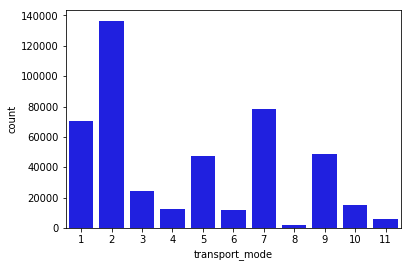

In [50]:
sns.countplot(train[train['label'] == 1]['transport_mode'], color = 'blue')

## Number of plans

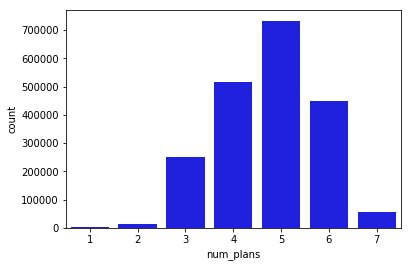

In [52]:
sns.countplot(train['num_plans'], color = 'blue')

## Click Rank for Multiple Plan Session

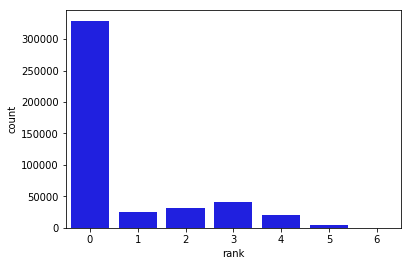

In [19]:
sns.countplot(train[(train['label'] == 1) & (train['num_plans'] > 1)]['rank'], color = 'blue')

# Feature Engineering

In [20]:
train = train[(train['num_plans'] > 1)]

In [37]:
def add_other_modes(df):
    temp = df.groupby('sid', as_index=False)['transport_mode']\
            .agg({'mode_list':lambda x: ','.join(sorted(x.astype(str), key = lambda x:int(x)))})
    df = df.merge(temp, on = 'sid')
    return df

In [38]:
%%time
train = add_other_modes(train)
test = add_other_modes(test)

CPU times: user 1min 41s, sys: 3.66 s, total: 1min 45s
Wall time: 1min 45s


In [21]:
def add_direction(df):
    df['lon_diff'] = df['O_lon'] - df['D_lon']
    df['lat_diff'] = df['O_lat'] - df['D_lat']
    return df

In [22]:
%%time
train = add_direction(train)
test = add_direction(test)

CPU times: user 182 ms, sys: 8.04 ms, total: 190 ms
Wall time: 143 ms


In [39]:
def add_cross_stats(df):
    for col in ['hr','dow','rank','mode_list']:
        colname = 'mode_'+ col + '_clicks'
        temp = train.groupby( [col, 'transport_mode'], as_index = False)\
                .agg({'label':np.mean}).rename(columns = {'label':colname})
        df = df.merge(temp, on = ['transport_mode', col], how = 'left')
        df[colname] = df[colname].fillna(0)
    return df

In [40]:
%%time
train = add_cross_stats(train)
test = add_cross_stats(test)

CPU times: user 6.66 s, sys: 4.63 s, total: 11.3 s
Wall time: 11.3 s


In [28]:
def add_max_min(df):
    cols = ['eta','distance','price']
    temp_columns = ['sid'] + [x + '_' + y for x in cols for y in ['min', 'max']]
    temp = df.groupby('sid', as_index = False).agg({'eta':[min, max], 'distance':[min, max], 'price':[min, max]})
    temp.columns = temp.columns.droplevel()
    temp.columns = temp_columns
    
    df = df.merge(temp, on = 'sid')
    for col in cols:
        for t in ['max', 'min']:
            df[col + '_' + t] = df[col] / (df[col + '_' + t] + 0.001)
    
    return df

In [29]:
%%time
train = add_max_min(train)
test = add_max_min(test)

CPU times: user 4.9 s, sys: 3.25 s, total: 8.15 s
Wall time: 7.79 s


In [50]:
def add_divide(df):
    df['eta_per_distance'] = df['eta'] / (df['distance'] + 0.001)
    df['price_per_distance'] = df['price'] / (df['distance'] + 0.001)
    df['price_per_eta'] = df['price'] / (df['eta'] + 0.001)
    
    temp = df.groupby('transport_mode', as_index = 'False').agg({'eta_per_distance':np.median,
                                                                 'price_per_distance':np.median,
                                                                 'price_per_eta':np.median}).reset_index()
    
    temp.columns  = ['transport_mode', 'eta_dis_avg','price_dis_avg','price_eta_avg']
    
    df = df.merge(temp, on = 'transport_mode')
    df['eta_per_distance'] = df['eta_per_distance'] / df['eta_dis_avg']
    df['price_per_distance'] = df['price_per_distance'] / df['price_dis_avg']
    df['price_per_eta'] = df['price_per_eta'] / df['price_eta_avg']
                           
    del df['eta_dis_avg']                                                     
    del df['price_dis_avg']
    del df['price_eta_avg']
    return df

In [51]:
%%time
train = add_divide(train)
test = add_divide(test)

CPU times: user 9.9 s, sys: 5.34 s, total: 15.2 s
Wall time: 15 s


In [52]:
train['price_NA'] = train['price'] == -1
test['price_NA'] = test['price'] == -1

In [53]:
def add_time(df):
    df['is_night'] = df['hr'].isin([23,0,1,2,3,4,5])
    df['is_weekend'] = df['dow'].isin([4,5])
    return df

In [54]:
%%time
train = add_time(train)
test = add_time(test)

CPU times: user 29.2 ms, sys: 2.03 ms, total: 31.2 ms
Wall time: 30.3 ms


In [71]:
def remove_profile(train, test):
    for i in range(0, 66):
        if train['p' + str(i)].mean() < 0.05:
            del train['p' + str(i)]
            del test['p' + str(i)]
    return train, test

In [72]:
%%time
train, test = remove_profile(train, test)

CPU times: user 19.4 s, sys: 17.2 s, total: 36.6 s
Wall time: 36.6 s


In [241]:
def add_weight(df, add_weight = False):
    if add_weight == False:
        return df
    else:
        temp = pd.DataFrame(train[(train['label'] == 1)]['transport_mode'].value_counts()).reset_index().sort_values(by = 'index')
        temp.columns = ['transport_mode', 'weight']
        temp['weight'] = np.sqrt(1 / temp['weight'] * 10000)
        temp.loc[temp['transport_mode'] == 3, 'weight'] = temp.loc[temp['transport_mode'] == 3, 'weight'] * 3
        temp.loc[temp['transport_mode'] == 9, 'weight'] = temp.loc[temp['transport_mode'] == 9, 'weight'] * 3
        temp = temp.merge(train[train['label'] == 1][['sid','transport_mode']], on = 'transport_mode')[['sid','weight']]
        temp['label'] = 1
        df = df.merge(temp, on = ['sid','label'], how = 'left')
        df['weight'] = df['weight'].fillna(1)
        return df

In [242]:
%%time
if 'weight' in train.columns:
    del train['weight']
train = add_weight(train, add_weight=True)

CPU times: user 3.54 s, sys: 2.09 s, total: 5.62 s
Wall time: 5.63 s


# Save intermediate data to pickle

In [243]:
%%time
data = {'train': train, 'test':test, 'all_test_sid':set(test_queries['sid'])}
with open('./processed_data/data.pickle', 'wb') as handle:
    pickle.dump(data, handle)

CPU times: user 2.03 s, sys: 762 ms, total: 2.8 s
Wall time: 2.9 s


In [244]:
%%time
with open('./processed_data/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

train = data['train']
test = data['test']

CPU times: user 957 ms, sys: 920 ms, total: 1.88 s
Wall time: 1.88 s


# Baseline LGB model

## Train/Validation Split

In [245]:
train_ = train.copy()
test_ = test.copy()

In [246]:
exclude_columns = ['sid',
                   'pid',
                   'profile',
                   'price_min',
                   'label',
                   'weight',
                   'mode_list',
                   'date'
                  ] 
features = [x for x in train_.columns if x not in exclude_columns]

In [1867]:
sid_train, sid_eval = train_test_split(list(set(train_['sid'])),
                                       test_size = 0.15, 
                                       random_state = 88)

In [247]:
sid_train = list(set(train_[(train_['date'] <  datetime.date(2018, 11, 24)) & \
                            (train_['date'] >  datetime.date(2018, 10, 7))]['sid']))
sid_eval  = list(set(train_[train_['date'] >= datetime.date(2018, 11, 24)]['sid']))

In [248]:
T = train_[train_['sid'].isin(sid_train)]
V = train_[train_['sid'].isin(sid_eval)]

In [249]:
X_train = T
X_eval  = V
y_train = T['label']
y_eval  = V['label']

## Model Training

In [250]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    #'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.9,
    'bagging_fraction': 1.0,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    #'reg_alpha':1,
    #'reg_lambda':1
}

In [251]:
lgb_train = lgb.Dataset(X_train[features], y_train, 
                        weight = X_train['weight'], 
                        categorical_feature = ['transport_mode'])
lgb_evals = lgb.Dataset(X_eval[features], y_eval, reference = lgb_train)

In [252]:
%%time
gbm_all = lgb.train(params,
                lgb_train,
                num_boost_round = 3000,
                valid_sets =[ lgb_train,lgb_evals],
                valid_names = ['train','valid'],
                early_stopping_rounds = 100,
                verbose_eval = 200
                )

Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.260445	valid's binary_logloss: 0.292211
[400]	train's binary_logloss: 0.255857	valid's binary_logloss: 0.291063
[600]	train's binary_logloss: 0.252133	valid's binary_logloss: 0.290481
[800]	train's binary_logloss: 0.248593	valid's binary_logloss: 0.290156
[1000]	train's binary_logloss: 0.245366	valid's binary_logloss: 0.289769
[1200]	train's binary_logloss: 0.242275	valid's binary_logloss: 0.289484
[1400]	train's binary_logloss: 0.239473	valid's binary_logloss: 0.289292
[1600]	train's binary_logloss: 0.236818	valid's binary_logloss: 0.289089
Early stopping, best iteration is:
[1638]	train's binary_logloss: 0.23628	valid's binary_logloss: 0.288983
CPU times: user 15min 2s, sys: 10.5 s, total: 15min 12s
Wall time: 1min 24s


In [253]:
feature_importance = sorted([(x,y) for x, y in zip(gbm_all.feature_name(), gbm_all.feature_importance())],
                            key = lambda x: x[1], reverse=True)
top_features = [x for x, y in feature_importance][:50]

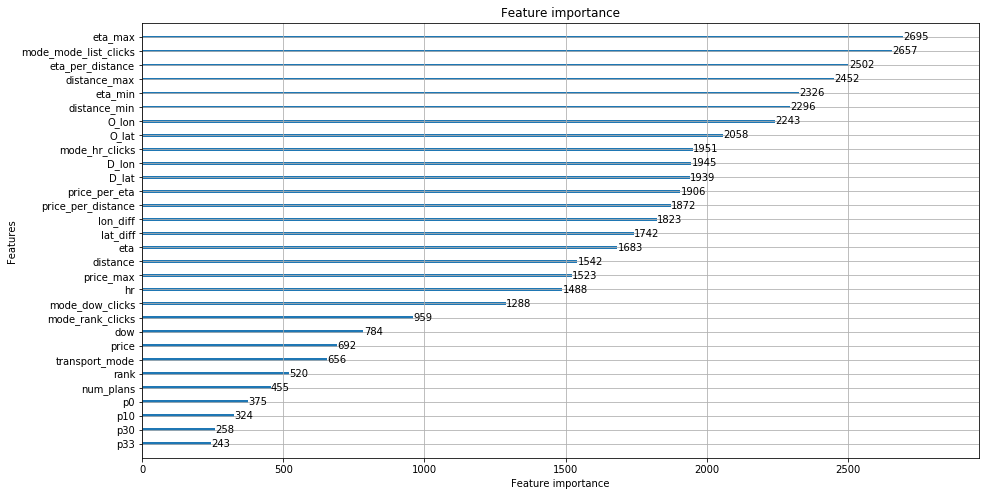

In [254]:
lgb.plot_importance(gbm_all, figsize=(15,8), max_num_features = 30)

**Generate predictions**

In [255]:
def get_best_mode_dt(gp):
    result = [(x, y) for x, y in zip(gp['transport_mode'], gp['pred_prob'])]
    result.sort(key = lambda x: x[1], reverse = True)
    return result[0][0]

In [256]:
def get_predictions_lgb(df, gbm, features):
    pred = gbm.predict(df[features])
    df['pred_prob'] = pred
    output = pd.DataFrame(df.groupby('sid').apply(get_best_mode_dt)).reset_index()
    output.columns = ['sid', 'recommend_mode']
    return df, output 

## Apply to validation set

In [257]:
X_eval, output = get_predictions_lgb(X_eval, gbm_all, features)

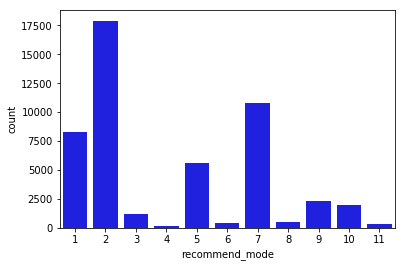

In [258]:
sns.countplot(output['recommend_mode'], color = 'blue')

In [259]:
eval_true = X_eval[X_eval['label'] == 1][['sid','transport_mode']]
eval_true.columns = ['sid','true']
output.columns = ['sid', 'pred']
eval_sum = eval_true.merge(output, on = 'sid')\

In [260]:
weight_f1 = f1_score(eval_sum['true'], eval_sum['pred'], average = 'weighted')

In [261]:
weight_f1 #0.745, 0.747, 0.748

0.7519845238289612

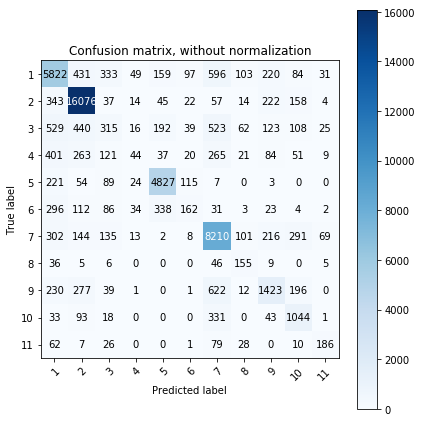

In [262]:
plot_confusion_matrix_(eval_sum['true'], eval_sum['pred'], classes=list(range(1,12)))

## Apply to test set

In [263]:
%%time
test_, output = get_predictions_lgb(test_, gbm_all, features)

CPU times: user 49.6 s, sys: 671 ms, total: 50.3 s
Wall time: 12.1 s


**Fill no-plan sessions with zeros**

In [264]:
set_1 = set(test_queries['sid'])
set_2 = set(test_['sid'])
no_click_sids = [x for x in set_1 if x not in set_2]
temp = pd.DataFrame({'sid': no_click_sids, 'recommend_mode':0})
output = pd.concat([output, temp], axis = 0, ignore_index=True)

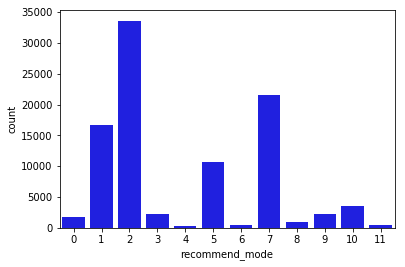

In [265]:
sns.countplot(output['recommend_mode'], color = 'blue')

**Export csv**

In [268]:
time_ = str(datetime.datetime.now())
mkdir('./submission/' + time_)

In [269]:
output['sid'] = output['sid'].astype(str)
output['recommend_mode'] = output['recommend_mode'].astype(str)
output.to_csv('./submission/' + time_ + '/submission.csv', index = False, quoting = csv.QUOTE_NONNUMERIC)